In [1]:
import torch
import torchvision.datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

from torchsummary import summary

import matplotlib.pyplot as plt

## Datasets

In [2]:
mnist_dataset = torchvision.datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=ToTensor()
)

In [3]:
train,val,test = torch.utils.data.random_split(mnist_dataset,(0.8,0.1,0.1))

In [6]:
batch_size = 512
train_loader = DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)
val_loader = DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

## Encoder

In [7]:
def Conv_block(in_channels,out_channels, kernel_size = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Encoder(nn.Module):
    def __init__(self, in_channels:int , latent_dims:int):
        super().__init__()
        self.convolutions = nn.Sequential(
            Conv_block(in_channels,128),
            Conv_block(128,256),
            Conv_block(256,512),
            Conv_block(512,1024)
        )

        self.Lineal = nn.Linear(1024,latent_dims)

    def forward(self,x):
        x = self.convolutions(x)
        x = self.Lineal(x.flatten(start_dim=1))
        return x

## Decoder

In [8]:
def conv_transpose_block(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=2,
        padding=1,
        output_padding=0,
        with_act=True
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding
            )   
    ]

    if with_act:
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())

    return nn.Sequential(*modules)


class Decoder(nn.Module):
    def __init__(self,out_channels:int , latent_dims:int):
        super().__init__()

        self.lineal = nn.Linear(latent_dims,1024*4*4)
        self.t_conv = nn.Sequential(
            conv_transpose_block(1024,512),
            conv_transpose_block(512,256,output_padding=1),
            conv_transpose_block(256,out_channels,output_padding=1,with_act=False)
        )

    def forward(self, x:torch.Tensor):
        bs = x.shape[0]

        x = self.lineal(x)
        x = x.reshape((bs,1024,4,4))
        x = self.t_conv(x)
        
        return x

## Autoencoder

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims:int):
        super().__init__()
        self.encoder = Encoder(in_channels,latent_dims)
        self.decoder = Decoder(in_channels,latent_dims)

    def encode(self,x):
        return self.encoder(x)

    def decode(self,x):
        return self.decoder(x)


    def forward(self,x):
        x = self.encode(x)
        x = self.decode(x)

        return x


In [10]:
model = AutoEncoder(in_channels=1, latent_dims=2).cuda().eval()
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                    [-1, 2]           2,050
          Encoder-14                   

In [11]:
batch_img = next(iter(train_loader))[0].cuda()
autoencoder_outut = model(batch_img)
autoencoder_outut.shape

torch.Size([512, 1, 28, 28])

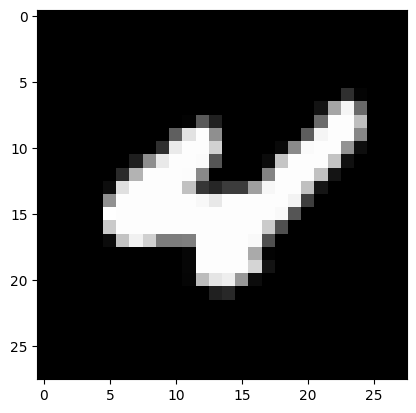

In [12]:
random_sample = torch.randint(batch_size,size=(1,))

plt.imshow(batch_img[random_sample].cpu().detach().squeeze(),cmap="grey");

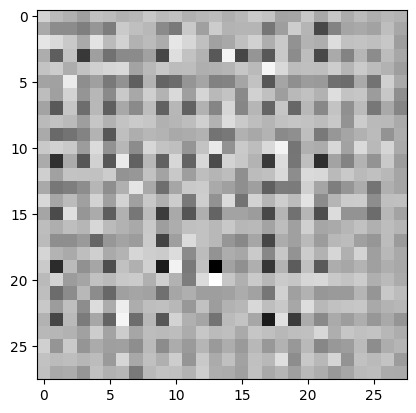

In [13]:
plt.imshow(autoencoder_outut[random_sample].cpu().detach().squeeze(),cmap="grey");


## Entrenamiento

In [15]:
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0

    losses_list = []

    for nlote,(x,_) in enumerate(loader):
        x = x.cuda()

        # Forward Pass
        logits = model(x)

        # Backpropagation
        loss = loss_fn(logits,x)    #Calculo de loss
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas caractgerísticas para plotear al final
        train_losses += loss.item()
        losses_list.append(loss.item())
        # train_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote: ",nlote)
            print("Loss: ",loss.item())

    train_losses /= nlotes
    print()
    print("\tLoss Promedio")
    print(f"\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [16]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.no_grad():       #Calcelo el calculo del gradiente
        for x,_ in loader:
            
            x = x.cuda()
            with torch.no_grad():
                logits = model(x)       # Inferencia
            
            loss = loss_fn(logits,x).item()

            val_losses += loss
            losses_list.append(loss)
            # val_accuracy += (logits.argmax(1)==y).type(torch.float).sum().item()

    val_losses /= nlotes

    print(f"\tLoss de Validación: {val_losses:>8f}")

    return losses_list


In [17]:
epochs = 10
lr = 0.0001

loss = nn.functional.mse_loss
optimizer = torch.optim.AdamW(model.parameters(),lr=lr,eps=1e-5)

In [18]:
training_losses = []
val_losses = []
for epoch in range(epochs):
    print(f"Itenración: {(epoch + 1)} / {epochs} -----------------------------")
    
    #Train
    tain_output = train_loop(train_loader,model,optimizer,loss)
    training_losses += tain_output
    
    #Validation
    val_output = val_loop(val_loader,model,loss)
    val_losses += val_output

print("Finalizado entrenamiento del modelo!")

Itenración: 1 / 10 -----------------------------
Nº de lote:  0
Loss:  14.536757469177246
Nº de lote:  10
Loss:  0.7086058259010315
Nº de lote:  20
Loss:  0.20436148345470428
Nº de lote:  30
Loss:  0.11733373999595642
Nº de lote:  40
Loss:  0.08552424609661102
Nº de lote:  50
Loss:  0.07510911673307419
Nº de lote:  60
Loss:  0.07124761492013931
Nº de lote:  70
Loss:  0.06864039599895477
Nº de lote:  80
Loss:  0.06828224658966064
Nº de lote:  90
Loss:  0.06822892278432846

	Loss Promedio
	Entrenamiento: 0.641655
	Loss de Validación: 0.065807
Itenración: 2 / 10 -----------------------------
Nº de lote:  0
Loss:  0.06784234195947647
Nº de lote:  10
Loss:  0.06524858623743057
Nº de lote:  20
Loss:  0.0648697167634964
Nº de lote:  30
Loss:  0.06420081853866577
Nº de lote:  40
Loss:  0.0635419636964798
Nº de lote:  50
Loss:  0.06174319609999657
Nº de lote:  60
Loss:  0.062419041991233826
Nº de lote:  70
Loss:  0.06139668449759483
Nº de lote:  80
Loss:  0.05843657627701759
Nº de lote:  90
Los

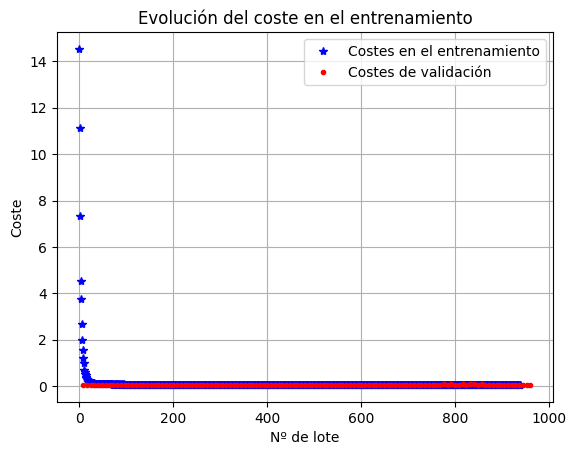

In [25]:
# len(val_losses)

plt.plot(range(len(training_losses)),training_losses,"b*",range(8,(len(val_losses)+1)*8,8),val_losses,"r.")
plt.grid()
plt.xlabel("Nº de lote")
plt.ylabel("Coste")
plt.title("Evolución del coste en el entrenamiento")
plt.legend(["Costes en el entrenamiento", "Costes de validación"]);


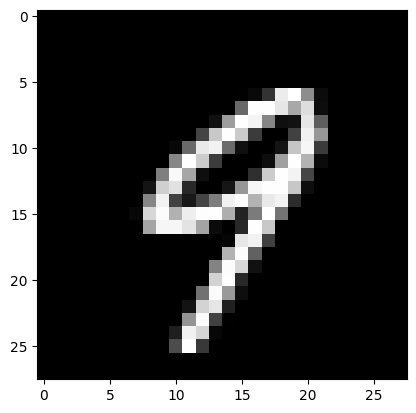

In [26]:
original_img = test[torch.randint(len(test),size=(1,))][0].unsqueeze(0).cuda()

processed_img = model(original_img)
plt.imshow(original_img.cpu().squeeze(),cmap="grey");

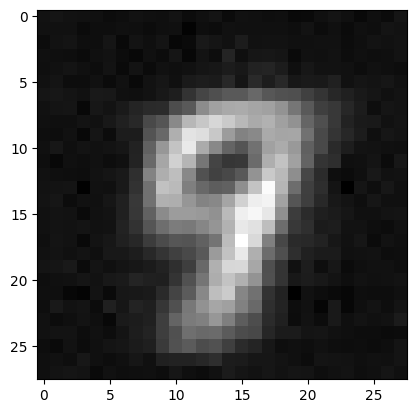

In [27]:
plt.imshow(processed_img.cpu().detach().squeeze(),cmap="grey");

## Interpretación de Espacio latente

In [22]:
# latent_coords = torch.zeros((len(test),2,1))

test_output = {
    0:[[],[]],
    1:[[],[]],
    2:[[],[]],
    3:[[],[]],
    4:[[],[]],
    5:[[],[]],
    6:[[],[]],
    7:[[],[]],
    8:[[],[]],
    9:[[],[]]
}

model.eval()
for img,lbl in test:

    # lbls_list.append(lbl)

    with torch.no_grad():
        output = model.encode(img.cuda().unsqueeze(1))
    
    test_output[lbl][0].append(output[0].cpu().tolist()[0])
    test_output[lbl][1].append(output[0].cpu().tolist()[1])

In [ ]:
test_output.keys()

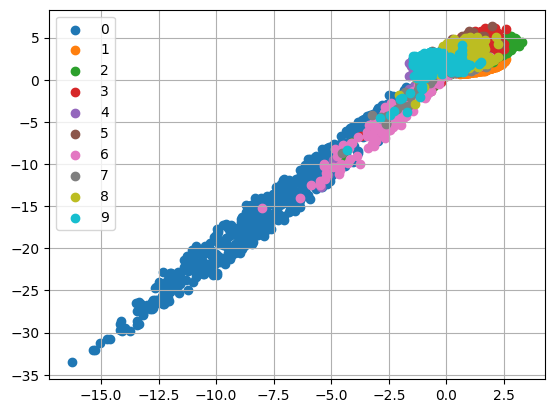

In [23]:
for key in test_output.keys():
    plt.scatter(test_output[key][0],test_output[key][1],label=key);
    # plt.plot(latent_coords[idx][0],latent_coords[idx][1],"*")
plt.legend();
plt.grid()

# Generación de nuevas imágenes

In [41]:
z = torch.Tensor([[1.5,6]]).cuda()
new_img = model.decode(z)

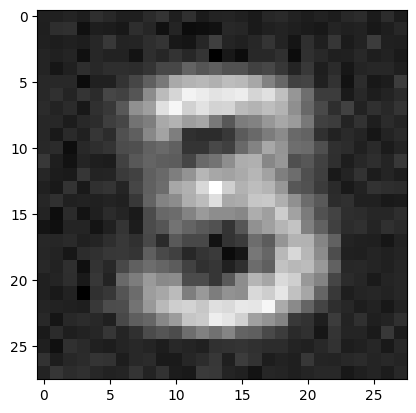

In [42]:
plt.imshow(new_img.cpu().detach().squeeze(),cmap="grey");